# Data Spilt (4 days for training; 3 days for test)

In [1]:
file_path = 'data/sourcedata/messages-20250602'

with open(file_path, 'r', encoding='utf-8') as f:
    first_line = f.readline().strip()
    lines = f.readlines()
    last_line = lines[-1].strip() if lines else first_line

first_time = first_line.split(' ', 1)[0]
last_time = last_line.split(' ', 1)[0]

print("Start:", first_time)
print("End:", last_time)

Start: 2025-05-25T03:49:02.730925+08:00
End: 2025-06-02T03:09:01.947552+08:00


In [2]:
import os
import pandas as pd
from datetime import timedelta
import re

folder = "data/sourcedata"
files = [os.path.join(folder, f) for f in os.listdir(folder) if f.startswith("messages-")]
latest_file = max(files, key=os.path.getmtime) # recent file
records = []
with open(latest_file, 'r', encoding='utf-8') as fh:
    for line in fh:
        ts, host, text = line.strip().split(' ', 2)
        records.append({'timestamp': ts, 'host': host, 'text': text})
df = pd.DataFrame(records)

# Timestamp --> datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Label recognition: only normal and abnormal
def label_fn(txt):
    if re.search(r'(?i)(error)', txt):
        return 'abnormal'
    else:
        return 'normal'

df['label'] = df['text'].apply(label_fn)

# Split first 4 days training set, and the remaining days test set
start_time = df['timestamp'].min()
trainingset_end_time = start_time + timedelta(days=4)
testingset_end_time = df['timestamp'].max() + timedelta(seconds=1)

training_set = df[(df['timestamp'] >= start_time) & (df['timestamp'] < trainingset_end_time)].reset_index(drop=True)
testing_set = df[(df['timestamp'] >= trainingset_end_time) & (df['timestamp'] < testingset_end_time)].reset_index(drop=True)

print(f"Training set: {len(training_set)} rows, from {training_set['timestamp'].min()} to {training_set['timestamp'].max()}")
print("Training set label counts:")
print(training_set['label'].value_counts())

print(f"Testing set: {len(testing_set)} rows, from {testing_set['timestamp'].min()} to {testing_set['timestamp'].max()}")
print("Testing set label counts:")
print(testing_set['label'].value_counts())


Training set: 3039491 rows, from 2025-05-25 03:49:02.730925+08:00 to 2025-05-29 03:49:02.548757+08:00
Training set label counts:
label
normal      3009717
abnormal      29774
Name: count, dtype: int64
Testing set: 3022293 rows, from 2025-05-29 03:49:02.892986+08:00 to 2025-06-02 03:09:01.947552+08:00
Testing set label counts:
label
normal      3009809
abnormal      12484
Name: count, dtype: int64


# Data Preprocess -- Training datasets

In [3]:
from datetime import timedelta

train_df = training_set.copy()

# Frequency limit (pandas groupby+diff）
train_df = train_df.sort_values(['label', 'text', 'timestamp'])
limit_map = {'abnormal': timedelta(seconds=10), 'normal': timedelta(seconds=10)}
train_df['prev_time'] = train_df.groupby(['label', 'text'])['timestamp'].shift()
train_df['time_diff'] = train_df['timestamp'] - train_df['prev_time']
train_df['limit'] = train_df['label'].map(limit_map)
mask = (train_df['prev_time'].isna()) | (train_df['time_diff'] >= train_df['limit'])
train_df = train_df[mask].drop(['prev_time', 'time_diff', 'limit'], axis=1)

# Deduplicate
train_df = train_df.sort_values(by='timestamp').drop_duplicates(subset=['text'], keep='first').reset_index(drop=True)

print(f"Total samples after processing: {len(train_df)}")
print("Count per class:")
print(train_df['label'].value_counts())

Total samples after processing: 1652559
Count per class:
label
normal      1651205
abnormal       1354
Name: count, dtype: int64


In [4]:
import os

# Downsample training datasets(500：500)
n_per_class = 500
train_abnormal = train_df[train_df['label'] == 'abnormal']
train_normal = train_df[train_df['label'] == 'normal']

train_abnormal_sample = train_abnormal.sample(n=min(n_per_class, len(train_abnormal)), random_state=42)
train_normal_sample = train_normal.sample(n=min(n_per_class, len(train_normal)), random_state=42)

# Sort by time
train_df_sampled = pd.concat([train_normal_sample, train_abnormal_sample]).sort_values('timestamp').reset_index(drop=True)

os.makedirs('data/sampledatasets', exist_ok=True)
train_df_sampled.to_json('data/sampledatasets/messages-train.jsonl', orient='records', lines=True, force_ascii=False)

print("Train set label counts:")
print(train_df_sampled['label'].value_counts())


Train set label counts:
label
abnormal    500
normal      500
Name: count, dtype: int64


In [5]:
import pandas as pd

sample_normal_train = train_df_sampled[train_df_sampled['label'] == 'normal'].sample(n=1, random_state=42)
sample_abnormal_train = train_df_sampled[train_df_sampled['label'] == 'abnormal'].sample(n=1, random_state=42)

print("Normal sample:")
print(sample_normal_train)
print("\nAbnormal sample:")
print(sample_abnormal_train)

Normal sample:
                           timestamp        host  \
787 2025-05-28 01:34:55.255558+08:00  hivenode02   

                                                text   label  
787  systemd: Starting Session 2104803 of user root.  normal  

Abnormal sample:
                           timestamp        host  \
683 2025-05-27 16:11:38.974792+08:00  hivenode02   

                                                  text     label  
683  named[7310]: error (network unreachable) resol...  abnormal  


# Data Preprocess -- Test datasets

In [6]:
test_df = testing_set.copy()

print(f"Total samples: {len(test_df)}")
print("Count per class:")
print(test_df['label'].value_counts())


Total samples: 3022293
Count per class:
label
normal      3009809
abnormal      12484
Name: count, dtype: int64


In [7]:
import os

# Downsample test datasets: 400 normal 100 abnormal
test_abnormal = test_df[test_df['label'] == 'abnormal']
test_normal = test_df[test_df['label'] == 'normal']

test_sample_normal = test_normal.sample(n=400, random_state=42)
test_sample_abnormal = test_abnormal.sample(n=100, random_state=42)

# Sort by time
test_df_sampled = pd.concat([test_sample_normal, test_sample_abnormal]).sort_values('timestamp').reset_index(drop=True)

os.makedirs('data/sampledatasets', exist_ok=True)
test_df_sampled.to_json('data/sampledatasets/messages-test.jsonl', orient='records', lines=True, force_ascii=False)

print("Test set label counts:")
print(test_df_sampled['label'].value_counts())


Test set label counts:
label
normal      400
abnormal    100
Name: count, dtype: int64


In [8]:
import pandas as pd

sample_normal_test = test_df_sampled[test_df_sampled['label'] == 'normal'].sample(n=1, random_state=42)
sample_abnormal_test = test_df_sampled[test_df_sampled['label'] == 'abnormal'].sample(n=1, random_state=42)

print("Normal sample:")
print(sample_normal_test)
print("\nAbnormal sample:")
print(sample_abnormal_test)

Normal sample:
                           timestamp        host  \
258 2025-05-31 09:30:16.900663+08:00  hivenode02   

                                                  text   label  
258  systemd: infi-celery.service holdoff time over...  normal  

Abnormal sample:
                           timestamp        host  \
380 2025-06-01 02:44:57.327960+08:00  hivenode02   

                                                  text     label  
380  named[7310]: error (network unreachable) resol...  abnormal  


# TS2Vec

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch #0: loss=1.6864597797393799
Epoch #1: loss=1.718261957168579
Epoch #2: loss=1.4939911365509033
Epoch #3: loss=1.6738173961639404
Epoch #4: loss=1.8853286504745483
Epoch #5: loss=1.8549444675445557
Epoch #6: loss=1.5262295007705688
Epoch #7: loss=1.9148924350738525
Epoch #8: loss=1.4988138675689697
Epoch #9: loss=1.812442421913147
Epoch #10: loss=1.816380500793457
Epoch #11: loss=1.649978518486023
Epoch #12: loss=1.6256086826324463
Epoch #13: loss=1.742671012878418
Epoch #14: loss=1.803786277770996
Epoch #15: loss=1.5430209636688232
Epoch #16: loss=1.5783573389053345
Epoch #17: loss=1.3316620588302612
Epoch #18: loss=1.8609554767608643
Epoch #19: loss=1.824989676475525
Epoch #20: loss=1.66866934299469
Epoch #21: loss=1.694204330444336
Epoch #22: loss=1.6992969512939453
Epoch #23: loss=1.717970609664917
Epoch #24: loss=1.7240406274795532
Epoch #25: loss=1.7931755781173706
Epoch #26: loss=1.7520493268966675
Epoch #27: loss=1.7205299139022827
Epoch #28: loss=1.5805765390396118
Epoch 

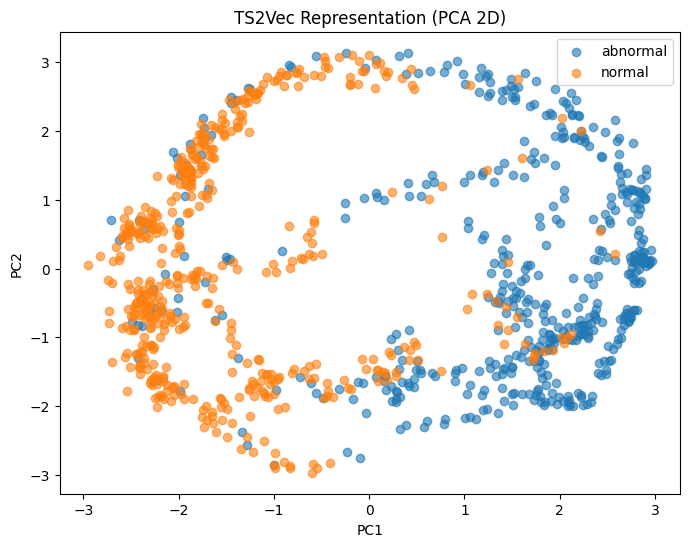

In [9]:
import sys
import os
sys.path.append(os.path.abspath('./ts2vec-main'))
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
from ts2vec import TS2Vec
import datautils
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Data Loading
train_df = pd.read_json('data/sampledatasets/messages-train.jsonl', lines=True)
test_df = pd.read_json('data/sampledatasets/messages-test.jsonl', lines=True)
train_df = train_df.sort_values('timestamp')
test_df = test_df.sort_values('timestamp')

# 2. Text Embedding
text_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
train_text_emb =text_model.encode(train_df['text'].tolist(), show_progress_bar=True, convert_to_tensor=False)
test_text_emb = text_model.encode(test_df['text'].tolist(), show_progress_bar=True, convert_to_tensor=False)

# 3. Label Embedding
unique_labels = train_df['label'].unique().tolist()
label_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
label_embs = label_model.encode(unique_labels, show_progress_bar=False, convert_to_tensor=False)
label_to_vec = {label: vec for label, vec in zip(unique_labels, label_embs)}

# 4. Timestamp float
for df in [train_df, test_df]:
    df['timestamp_float'] = df['timestamp'].astype(np.int64) // 10**9
ts_min = min(train_df['timestamp_float'].min(), test_df['timestamp_float'].min())
ts_max = max(train_df['timestamp_float'].max(), test_df['timestamp_float'].max())
for df in [train_df, test_df]:
    df['timestamp_norm'] = (df['timestamp_float'] - ts_min) / (ts_max - ts_min)

# 5. Prepare for ts2vec shape:(n_instances, n_timestamps, n_features); n_instances=1 only hivenode 2.
train_data = train_text_emb[np.newaxis, :]
test_data= test_text_emb[np.newaxis, :]

# 6. TS2Vec for training datasets
model_ts2vec = TS2Vec(input_dims=train_data.shape[2], device=0, output_dims=320)
model_ts2vec.fit(train_data, verbose=True)

# 7. Encode the data
train_repr = model_ts2vec.encode(train_data)
test_repr = model_ts2vec.encode(test_data)

train_df['text_repr'] = list(train_repr[0])
test_df['text_repr'] = list(test_repr[0])
train_df['label_vec'] = train_df['label'].map(label_to_vec)
test_df['label_vec'] = test_df['label'].map(label_to_vec)
train_features = np.concatenate([np.stack(train_df['text_repr'].values), train_df['timestamp_norm'].values[:, None]], axis=1)
test_features = np.concatenate([np.stack(test_df['text_repr'].values), test_df['timestamp_norm'].values[:, None]], axis=1)

# 8. Test the quality
pca = PCA(n_components=2)
train_vec_2d = pca.fit_transform(np.stack(train_df['text_repr'].values))

plt.figure(figsize=(8, 6))
for label in train_df['label'].unique():
    idx = train_df['label'] == label
    plt.scatter(train_vec_2d[idx, 0], train_vec_2d[idx, 1], label=label, alpha=0.6)
plt.title('TS2Vec Representation (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# 9. Save the processed data
os.makedirs('data/embeddata', exist_ok=True)
# Save TS2Vec representations
train_df.to_json('data/embeddata/messages-train-ts2vec.jsonl', orient='records', lines=True, force_ascii=False)
test_df.to_json('data/embeddata/messages-test-ts2vec.jsonl', orient='records', lines=True, force_ascii=False)

In [10]:
import numpy as np
import torch

train_df = pd.read_json('data/embeddata/messages-train-ts2vec.jsonl', lines=True)
test_df = pd.read_json('data/embeddata/messages-test-ts2vec.jsonl', lines=True)
rand_idx_train = np.random.randint(len(train_df))
rand_idx_test = np.random.randint(len(test_df))
print(f"Train: {rand_idx_train}")
print(train_df.iloc[rand_idx_train])
print(f"Test: {rand_idx_test}")
print(train_df.iloc[rand_idx_test])

torch.cuda.empty_cache()


Train: 956
timestamp                                 2025-05-28 18:28:58.361000
host                                                      hivenode02
text               named[7310]: error (network unreachable) resol...
label                                                       abnormal
timestamp_float                                  2025-05-28 18:28:58
timestamp_norm                                              0.494899
text_repr          [-0.43640601630000003, -0.2892592549, -0.24940...
label_vec          [0.0719301552, 0.019292343400000002, -0.009730...
Name: 956, dtype: object
Test: 452
timestamp                                 2025-05-26 13:02:10.206000
host                                                      hivenode02
text                  systemd: Started Session 2039242 of user root.
label                                                         normal
timestamp_float                                  2025-05-26 13:02:10
timestamp_norm                                           

# LLM(GPT2) & Fine-Tunning

Epoch 1/10  avg_loss=0.2079
Epoch 2/10  avg_loss=0.0199
Epoch 2/10  avg_loss=0.0199
Epoch 3/10  avg_loss=0.0091
Epoch 3/10  avg_loss=0.0091
Epoch 4/10  avg_loss=0.0066
Epoch 4/10  avg_loss=0.0066
Epoch 5/10  avg_loss=0.0058
Epoch 5/10  avg_loss=0.0058
Epoch 6/10  avg_loss=0.0057
Epoch 6/10  avg_loss=0.0057
Epoch 7/10  avg_loss=0.0074
Epoch 7/10  avg_loss=0.0074
Epoch 8/10  avg_loss=0.0047
Epoch 8/10  avg_loss=0.0047
Epoch 9/10  avg_loss=0.0043
Epoch 9/10  avg_loss=0.0043
Epoch 10/10  avg_loss=0.0051
Epoch 10/10  avg_loss=0.0051


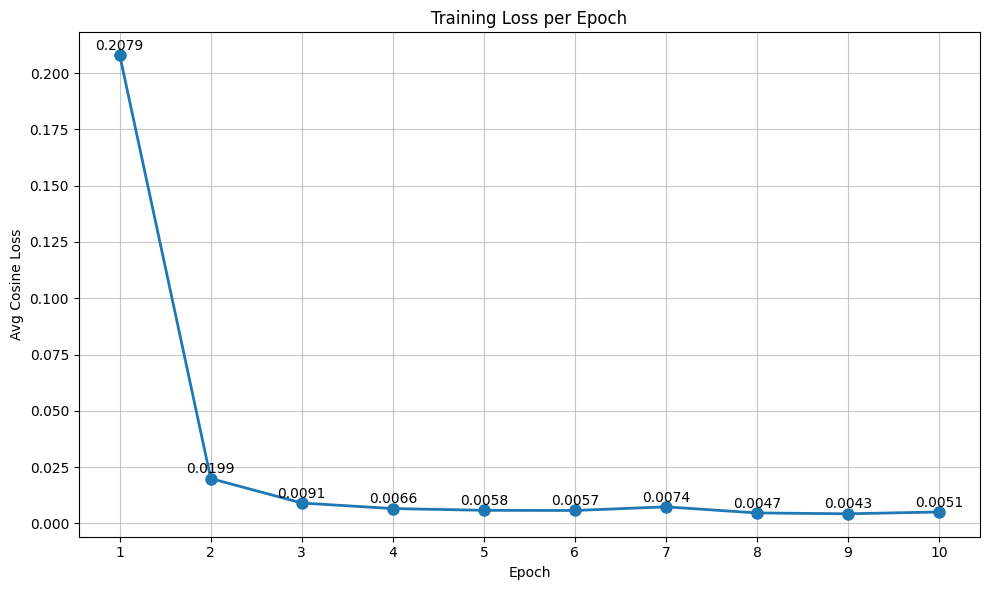

ITOpts-LLM-Prediction Model Performance:
Accuracy: 0.9800
Macro Recall: 0.9613
Macro Precision: 0.9757
Macro F1-Score: 0.9683

Detailed Classification Report:
              precision    recall  f1-score   support

    abnormal       0.97      0.93      0.95       100
      normal       0.98      0.99      0.99       400

    accuracy                           0.98       500
   macro avg       0.98      0.96      0.97       500
weighted avg       0.98      0.98      0.98       500



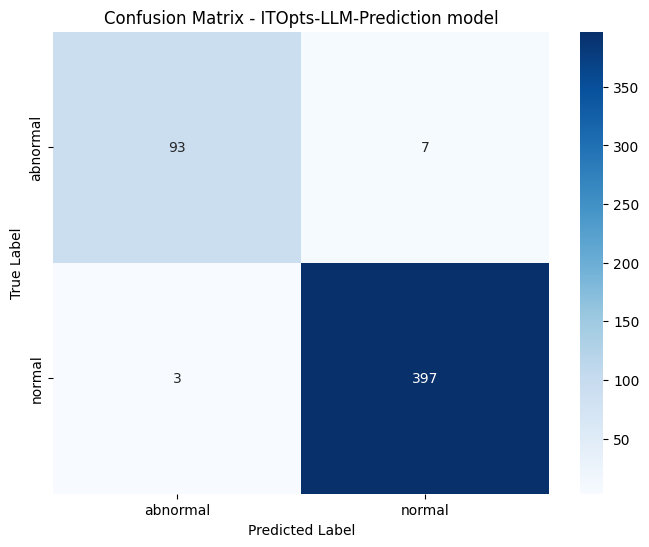


Model Performance Comparison:
--------------------------------------------------------------------------------
Model           Accuracy   Macro_Recall  Macro_Precision  Macro_F1  
--------------------------------------------------------------------------------
ITOpts-LLM-Prediction model 0.9800     0.9613        0.9757           0.9683    
SVM             0.9500     0.8788        0.9651           0.9142    
RF              0.9140     0.7925        0.9369           0.8408    
DT              0.8780     0.7662        0.8270           0.7906    


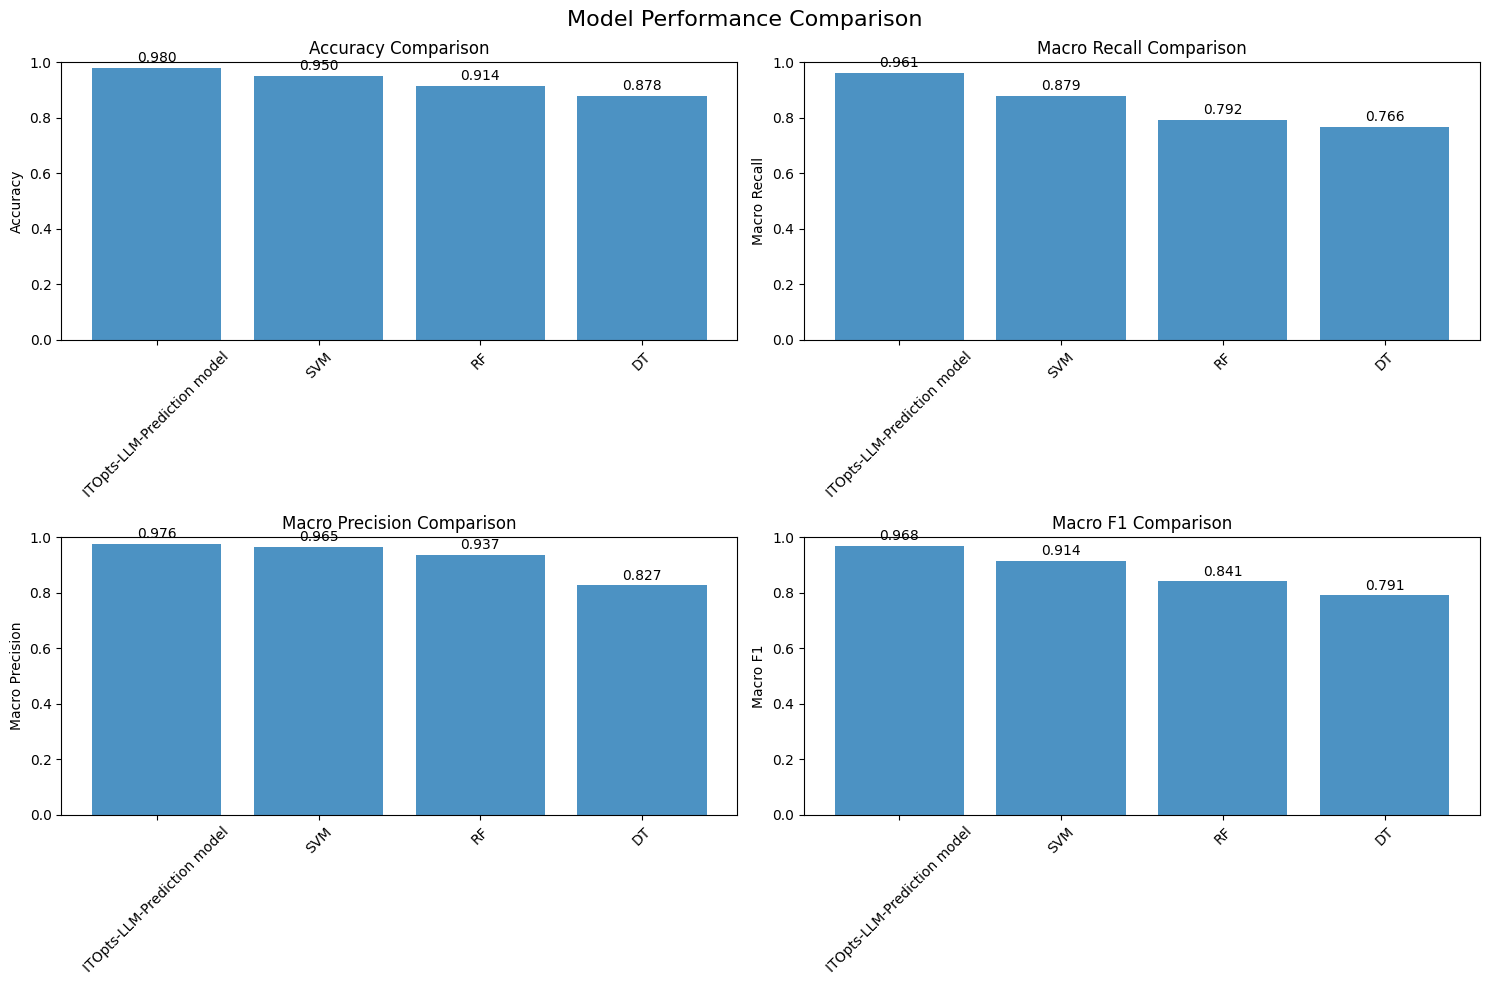


Per-class Performance (Important for Anomaly Detection):
------------------------------------------------------------

ITOpts-LLM-Prediction model:
  abnormal: Precision=0.9688, Recall=0.9300, F1=0.9490
  normal: Precision=0.9827, Recall=0.9925, F1=0.9876

SVM:
  abnormal: Precision=0.9870, Recall=0.7600, F1=0.8588
  normal: Precision=0.9433, Recall=0.9975, F1=0.9696

RF:
  abnormal: Precision=0.9672, Recall=0.5900, F1=0.7329
  normal: Precision=0.9066, Recall=0.9950, F1=0.9487

DT:
  abnormal: Precision=0.7532, Recall=0.5800, F1=0.6554
  normal: Precision=0.9007, Recall=0.9525, F1=0.9259
  abnormal: Precision=0.9672, Recall=0.5900, F1=0.7329
  normal: Precision=0.9066, Recall=0.9950, F1=0.9487

DT:
  abnormal: Precision=0.7532, Recall=0.5800, F1=0.6554
  normal: Precision=0.9007, Recall=0.9525, F1=0.9259


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Config, GPT2Model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Loading 
train_df = pd.read_json('data/embeddata/messages-train-ts2vec.jsonl', lines=True)
test_df  = pd.read_json('data/embeddata/messages-test-ts2vec.jsonl',  lines=True)

# 2. Tensor input
# (text_repr + timestamp_norm) -> tensor
def vec2tensor(df):
    tr = np.stack(df['text_repr'].values)
    tm = df['timestamp_norm'].values[:,None]
    return torch.tensor(np.concatenate([tr, tm], axis=1), dtype=torch.float32)

X_train = vec2tensor(train_df)
X_test  = vec2tensor(test_df)

Y_train = torch.tensor(np.stack(train_df['label_vec'].values), dtype=torch.float32)
Y_test  = torch.tensor(np.stack(test_df['label_vec'].values),  dtype=torch.float32)

# Mapping(label text ↔ id mappings)
labels = list(train_df['label'].unique())
label_to_id = {l:i for i,l in enumerate(labels)}
id_to_label = {i:l for l,i in label_to_id.items()}

# Mapping(label ↔ label vector)
Txt2Vec = { l: np.stack(train_df.loc[train_df['label']==l,'label_vec'].values)[0] for l in labels }

# Mapping(label id ↔ label)
Vec2Txt = { i: l for i,l in enumerate(labels) }  

# 3. Dataloader
class VLTDataset(Dataset):
    def __init__(self, X, Y): self.X, self.Y = X, Y
    def __len__(self): return len(self.X)
    def __getitem__(self,i): return self.X[i], self.Y[i]
bs = 32
train_loader = DataLoader(VLTDataset(X_train, Y_train), batch_size=bs, shuffle=True)
test_loader  = DataLoader(VLTDataset(X_test,  Y_test),  batch_size=bs)

# 4. GPT2 Transformer: proj → GPT2Model → vector out
class GPT2VecPredictor(nn.Module):
    def __init__(self, inp_dim, hidden_dim, out_dim):
        super().__init__()
        cfg = GPT2Config(n_embd=hidden_dim, n_layer=4, n_head=4)
        self.proj = nn.Linear(inp_dim, hidden_dim)
        self.enc  = GPT2Model(cfg)
        self.out  = nn.Linear(hidden_dim, out_dim)
    def forward(self, x):
        h = self.proj(x).unsqueeze(1)                   # [B,1,H]
        z = self.enc(inputs_embeds=h).last_hidden_state  # [B,1,H]
        return self.out(z[:,0])                         # [B, out_dim]

device = 0
model = GPT2VecPredictor(X_train.shape[1], hidden_dim=128, out_dim=Y_train.shape[1]).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=5e-4)
cos   = nn.CosineSimilarity(dim=1)

# 5. Train (cosine loss) & Improved Visualization
epochs, thresh = 10, 0.7
loss_history = []

for ep in range(epochs):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pv = model(xb)
        loss = torch.mean(1 - cos(pv, yb))
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    loss_history.append(avg_loss)
    print(f"Epoch {ep+1}/{epochs}  avg_loss={avg_loss:.4f}")


plt.figure(figsize=(10,6))
plt.plot(range(1, epochs+1), loss_history, marker='o', linewidth=2, markersize=8)
max_loss = max(loss_history)
for i, v in enumerate(loss_history, 1):
    plt.text(i, v + 0.005*max_loss, f"{v:.4f}", ha='center', va='bottom')
plt.xticks(range(1, epochs+1))
plt.xlabel('Epoch')
plt.ylabel('Avg Cosine Loss')
plt.title('Training Loss per Epoch')
plt.grid('--', alpha=0.7)
plt.tight_layout()
plt.show()


# 6. Inference + mapping to discrete labels
model.eval()
y_true = train_df['label'].map(label_to_id).tolist()  # train labels not used below
y_test_ids = test_df['label'].map(label_to_id).tolist()

all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        pv = model(xb).cpu().numpy()  # [b, vec_dim]
        for v in pv:
            sims = [ np.dot(v, Txt2Vec[l])/(np.linalg.norm(v)*np.linalg.norm(Txt2Vec[l])) 
                     for l in labels ]
            best, idx = max((s,i) for i,s in enumerate(sims))
            all_preds.append(idx if best>=thresh else -1)

recall_gpt2 = recall_score(y_test_ids, all_preds, average='macro', zero_division=0)
precision_gpt2 = precision_score(y_test_ids, all_preds, average='macro', zero_division=0)
f1_gpt2 = f1_score(y_test_ids, all_preds, average='macro', zero_division=0)
accuracy_gpt2 = accuracy_score(y_test_ids, all_preds)

print(f"ITOpts-LLM-Prediction Model Performance:")
print(f"Accuracy: {accuracy_gpt2:.4f}")
print(f"Macro Recall: {recall_gpt2:.4f}")
print(f"Macro Precision: {precision_gpt2:.4f}")
print(f"Macro F1-Score: {f1_gpt2:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test_ids, all_preds, target_names=[id_to_label.get(i, f'Unknown_{i}') for i in range(len(labels))], zero_division=0))
cm = confusion_matrix(y_test_ids, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id_to_label.get(i, f'Unknown_{i}') for i in range(len(labels))],
            yticklabels=[id_to_label.get(i, f'Unknown_{i}') for i in range(len(labels))])
plt.title('Confusion Matrix - ITOpts-LLM-Prediction model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 7. Traditional ML baselines with comprehensive metrics
X_tr = X_train.numpy(); X_te = X_test.numpy()
y_tr = train_df['label'].map(label_to_id).values
y_te = y_test_ids
metrics = ['Accuracy', 'Macro_Recall', 'Macro_Precision', 'Macro_F1']
results = {metric: {} for metric in metrics}
results['Accuracy']['ITOpts-LLM-Prediction model'] = accuracy_gpt2
results['Macro_Recall']['ITOpts-LLM-Prediction model'] = recall_gpt2
results['Macro_Precision']['ITOpts-LLM-Prediction model'] = precision_gpt2
results['Macro_F1']['ITOpts-LLM-Prediction model'] = f1_gpt2
for name, Clf in [('SVM', SVC()), ('RF', RandomForestClassifier()), ('DT', DecisionTreeClassifier())]:
    clf = Clf.fit(X_tr, y_tr)
    y_p = clf.predict(X_te)
    
    results['Accuracy'][name] = accuracy_score(y_te, y_p)
    results['Macro_Recall'][name] = recall_score(y_te, y_p, average='macro', zero_division=0)
    results['Macro_Precision'][name] = precision_score(y_te, y_p, average='macro', zero_division=0)
    results['Macro_F1'][name] = f1_score(y_te, y_p, average='macro', zero_division=0)

print("\nModel Performance Comparison:")
print("-" * 80)
print(f"{'Model':<15} {'Accuracy':<10} {'Macro_Recall':<13} {'Macro_Precision':<16} {'Macro_F1':<10}")
print("-" * 80)
for model in results['Accuracy'].keys():
    acc = results['Accuracy'][model]
    rec = results['Macro_Recall'][model] 
    pre = results['Macro_Precision'][model]
    f1 = results['Macro_F1'][model]
    print(f"{model:<15} {acc:<10.4f} {rec:<13.4f} {pre:<16.4f} {f1:<10.4f}")

# 8. Multi-metric comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    models = list(results[metric].keys())
    values = list(results[metric].values())
    
    bars = ax.bar(models, values, alpha=0.8)
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric.replace('_', ' '))
    ax.set_title(f'{metric.replace("_", " ")} Comparison')
    ax.tick_params(axis='x', rotation=45)

    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 9. Special metrics for anomaly detection tasks
print("\nPer-class Performance (Important for Anomaly Detection):")
print("-" * 60)
for model_name in results['Accuracy'].keys():
    print(f"\n{model_name}:")
    if model_name == 'ITOpts-LLM-Prediction model':
        y_pred = np.array(all_preds)
    else:
        clf_map = {'SVM': SVC(), 'RF': RandomForestClassifier(), 'DT': DecisionTreeClassifier()}
        clf = clf_map[model_name].fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
    
    y_pred = np.array(y_pred)
    y_te_array = np.array(y_te)
    
    for i, label_name in enumerate([id_to_label[j] for j in range(len(labels))]):
        true_pos = np.sum((y_te_array == i) & (y_pred == i))
        false_pos = np.sum((y_te_array != i) & (y_pred == i))
        false_neg = np.sum((y_te_array == i) & (y_pred != i))
        
        precision_class = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall_class = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1_class = 2 * precision_class * recall_class / (precision_class + recall_class) if (precision_class + recall_class) > 0 else 0
        
        print(f"  {label_name}: Precision={precision_class:.4f}, Recall={recall_class:.4f}, F1={f1_class:.4f}")
